In [1]:
import sys
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings 

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)


ROOT = Path.cwd().parent
DATA = ROOT / "data"


sys.path.append(str(ROOT / "functions"))
from utils import reduce_mem_usage, grab_col_names ,  resumetable , top_missing_cols
from num_functions import *

In [2]:
train_path = DATA / "train_merged.csv"
df = pd.read_csv(train_path, low_memory=False)
print(df.shape)

(590540, 434)


In [3]:
train_df = reduce_mem_usage(df.copy())

categorical_features = [
    'ProductCD', 'P_emaildomain', 'R_emaildomain','DeviceType', 'DeviceInfo',
    'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
    'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20',
    'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
    'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'
]
numerical_features = [col for col in train_df.columns if col not in categorical_features]

train_df = train_df[numerical_features]
# resumetable(train_df[categorical_features])[:15]

Memory usage decreased to 645.97 Mb (67.0% reduction)


## Numerical Features
* TransactionAMT: transaction payment amount in USD
* dist1,dist2: some distance information
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: time delta, such as days between the previous transactions, etc.
* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
* Transaction id: Id related to the transaction

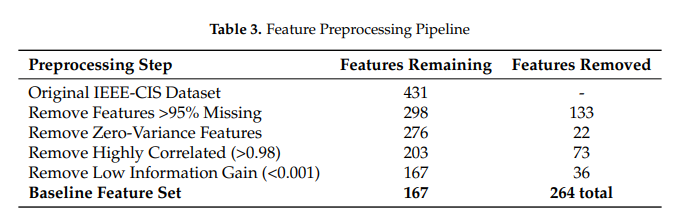


In [4]:
missing_df = top_missing_cols(train_df, n=None, thresh=95)

cols_to_drop = missing_df[missing_df['missing_percent'] > 95]['col'].tolist()

# print(f"Columns to drop: {cols_to_drop}")
train_df = train_df.drop(columns=cols_to_drop)

print(f"New shape: {train_df.shape}")

There are 367 columns with missing values.
There are 2 columns with missing percent > 95%
New shape: (590540, 383)


### Dikkat edilmesi gerekenler.

**Yapısal Eksiklik (Structural Missingness)**: Veri setindeki eksik değerler (NaN), rastgele dağılmamıştır. Örneğin, bir işlemde "Adres Doğrulama" (AVS) yapılmadıysa, adresle ilgili tüm V sütunları aynı anda NaN değeri alır. Bu eksiklik, aslında bir bilgi taşır.   

**Yüksek Boyutluluk ve Çoklu Bağlantı (Multicollinearity)**

**Zaman Kayması (Concept Drift)**: Dolandırıcılık taktikleri zamanla değişir. Veri seti zamana dayalı (time-series) bir yapıdadır. Eğitim setindeki davranış kalıpları, test setinin son aylarında geçerliliğini yitirebilir. Bu nedenle sayısal özelliklerin "zamana dirençli" (time-invariant) olması gerekir.


**Özellik Seçimi Stratejisi**: Literatür, tüm özellikleri modele vermek yerine, "korelasyon analizi" ve "önem skoru" (feature importance) bazlı eleme yapılmasını önermektedir. Özellikle sayısal verilerde, birbiriyle yüksek korelasyonlu (r > 0.90) özellik gruplarından sadece bir "temsilci" (representative) özelliğin seçilmesi, modelin kararlılığını artırmaktadır.

**Aykırı Değer (Outlier) Yönetimi**: Finansal verilerde tutarlar (Amount) genellikle "Power Law" (Güç Yasası) dağılımı gösterir. Çoğu işlem küçüktür, ancak çok az sayıda işlem devasa tutarlardadır. Akademik çalışmalar, bu tür verilerin doğrudan kullanılmamasını, bunun yerine Logaritmik dönüşüm ($Log(1+x)$) veya Z-skoru dönüşümü uygulanmasını önermektedir.


# Özellik Seçimi
KS testi uygulanacak.
Yüksek ve çok düşük korelasyonlu özelliklerden biri çıkarılacak.
V ile başlayan özellikler gruplanacak.

V sütunlarını analiz ettiğimizde, bazı sütunların her zaman birlikte NaN değerine sahip olduğunu görürüz. Bu, onların aynı "kaynaktan" veya aynı "doğrulama sürecinden" geldiğini gösterir. Araştırmalar , 15 ana V grubu belirlemiştir. Gruplama işini buna göre yapıyoruz aslında. V ile başlayan ve aynı tamamen gözlemler için missing olanları gruplarsan eğer 15 tane grup kalıyor geriye. 



In [5]:
v_cols = [col for col in train_df.columns if col.startswith('V')] 
c_cols = [col for col in train_df.columns if col.startswith('C')]
d_cols = [col for col in train_df.columns if col.startswith('D')]
id_cols = [col for col in train_df.columns if col.startswith('id_')]

grouped_cols = set(v_cols + c_cols + d_cols + id_cols) # bunlardan olmayanları bulmak için

indep_cols = [col for col in train_df.columns if col not in grouped_cols]

Bu listeler sonradan güncellenecek tabi ki...

In [9]:
train_df.shape[1] - (len(v_cols) + len(c_cols)  + len(d_cols)+ len(id_cols)) # bu listeler dışında kalan 14 tane özellik var.

6

In [6]:
indep_cols

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'dist1',
 'dist2']

id sütunları için KS testi ve görsel inceleme.

  Feature  Test_Stat   P_Value
0   id_01     0.2155  0.000000
1   id_06     0.0997  0.000000
2   id_02     0.0854  0.000000
3   id_05     0.0638  0.000000
4   id_09     0.0513  0.000000
5   id_03     0.0492  0.000000
6   id_04     0.0140  0.164477
7   id_11     0.0089  0.379979
8   id_10     0.0049  0.995791


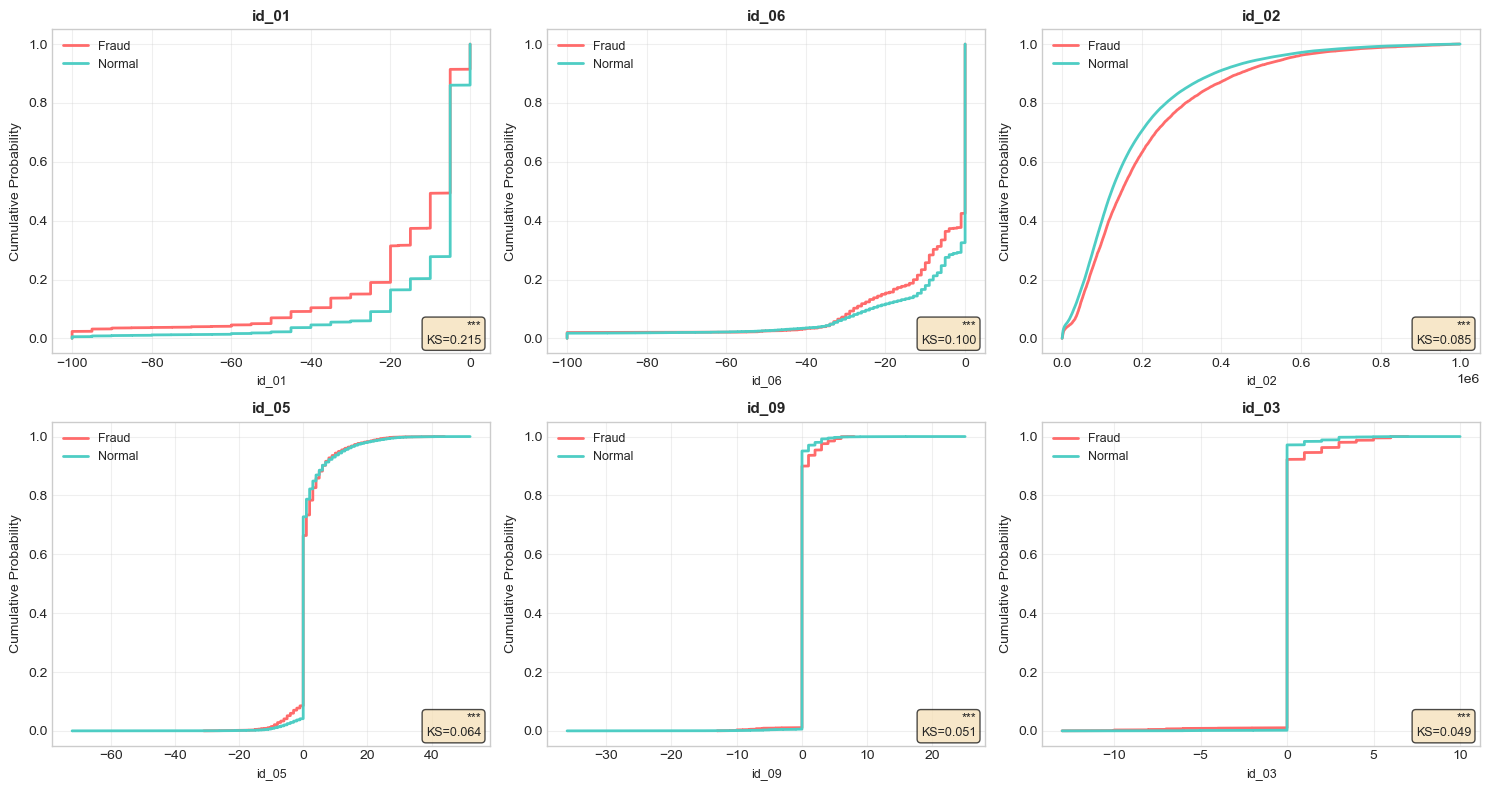

In [12]:
results = test_feature_discrimination(
    train_df, 
    columns=id_cols,
    test='ks'
)

print(results[['Feature', 'Test_Stat', 'P_Value']])

# En anlamlı 6 tansini görselleştiriyoruz sayı arttırılabilir.
top_6 = results.head(6)['Feature'].tolist()
plot_distribution_comparison(train_df, top_6, plot_type='cdf')

C ile başlayan sayısal özellikler için KS testi ve görsel inceleme

   Feature  Test_Stat   P_Value
0       C4     0.3310  0.000000
1       C8     0.3163  0.000000
2      C10     0.3119  0.000000
3      C12     0.2967  0.000000
4       C9     0.2921  0.000000
5       C5     0.2872  0.000000
6       C7     0.2785  0.000000
7       C2     0.2043  0.000000
8      C14     0.1984  0.000000
9      C13     0.1886  0.000000
10      C1     0.1876  0.000000
11     C11     0.1854  0.000000
12      C6     0.1328  0.000000
13      C3     0.0040  0.904013


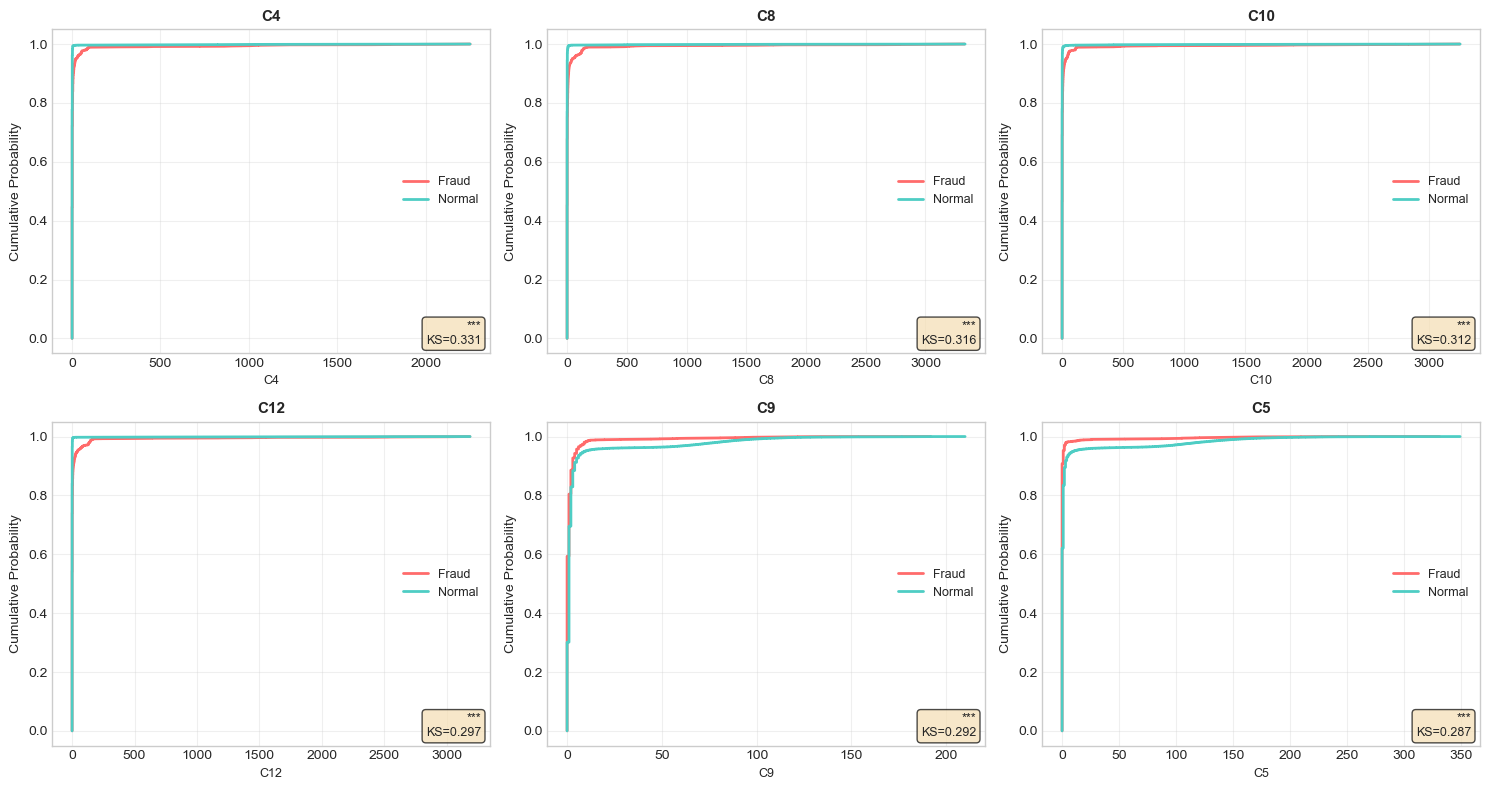

In [13]:
results = test_feature_discrimination(
    train_df, 
    columns=c_cols,
    test='ks'
)

print(results[['Feature', 'Test_Stat', 'P_Value']])

# En anlamlı 6 tansini görselleştiriyoruz sayı arttırılabilir.
top_6 = results.head(6)['Feature'].tolist()
plot_distribution_comparison(train_df, top_6, plot_type='cdf')

D ile başlayan özellikler için inceleme

   Feature  Test_Stat  P_Value
0       D5     0.4371      0.0
1       D3     0.3618      0.0
2       D2     0.3248      0.0
3       D8     0.3139      0.0
4       D7     0.2694      0.0
5      D10     0.2624      0.0
6      D15     0.2485      0.0
7       D1     0.2104      0.0
8       D4     0.1946      0.0
9      D11     0.1593      0.0
10     D14     0.1281      0.0
11      D9     0.1229      0.0
12     D12     0.1194      0.0
13      D6     0.0833      0.0
14     D13     0.0722      0.0


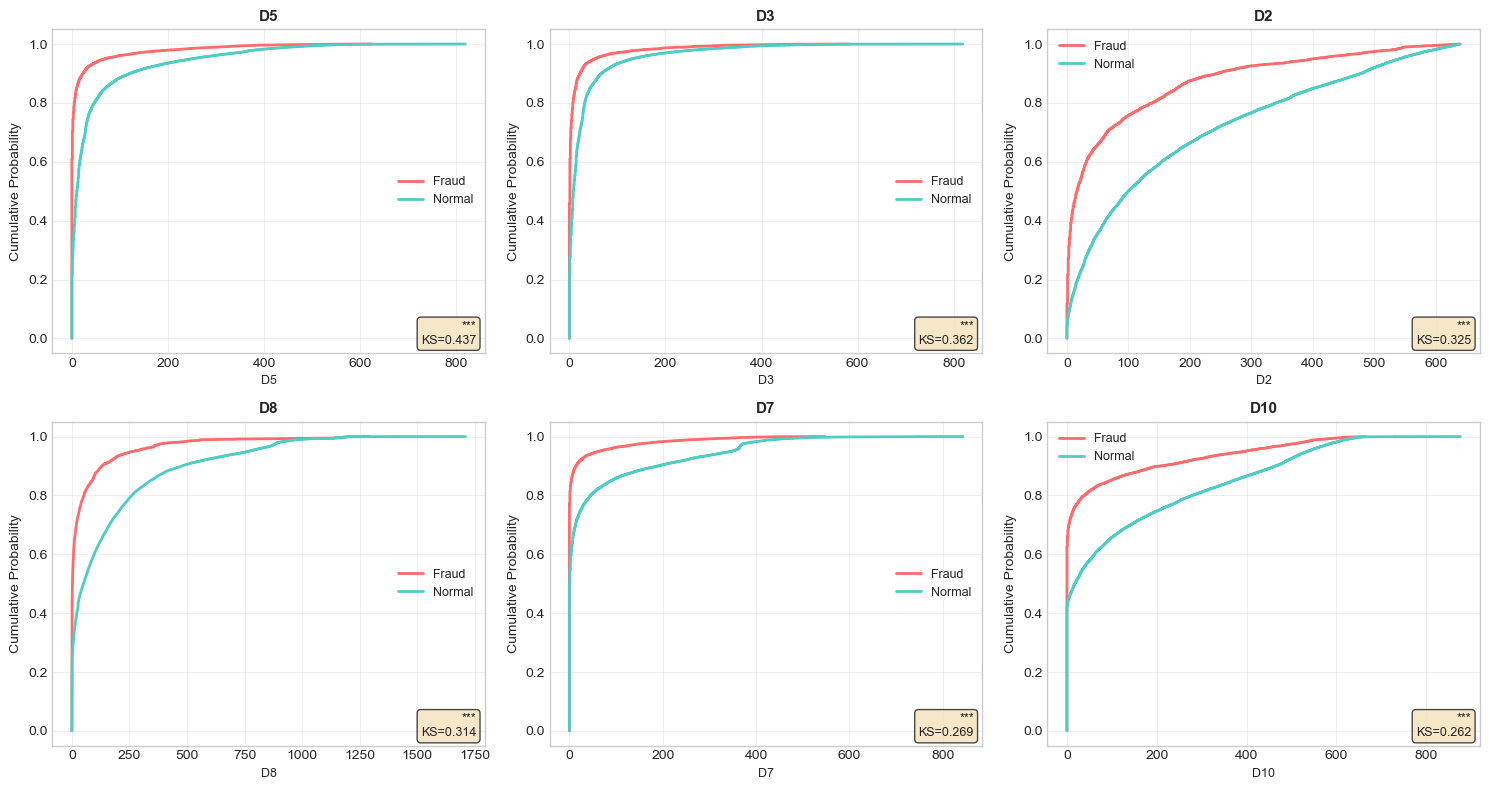

In [26]:
results = test_feature_discrimination(
    train_df, 
    columns=d_cols,
    test='ks'
)

print(results[['Feature', 'Test_Stat', 'P_Value']])

# En anlamlı 6 tansini görselleştiriyoruz sayı arttırılabilir.
top_6 = results.head(6)['Feature'].tolist()
plot_distribution_comparison(train_df, top_6, plot_type='cdf')

V ile başalayan özelliklerin eksik değerleri rastgele değil birbirine bağlı diyorlar bu bilgiden faydalanmak lazım.
Ayrıca bunlardaki eksik değerleri analiz edebiliiz.

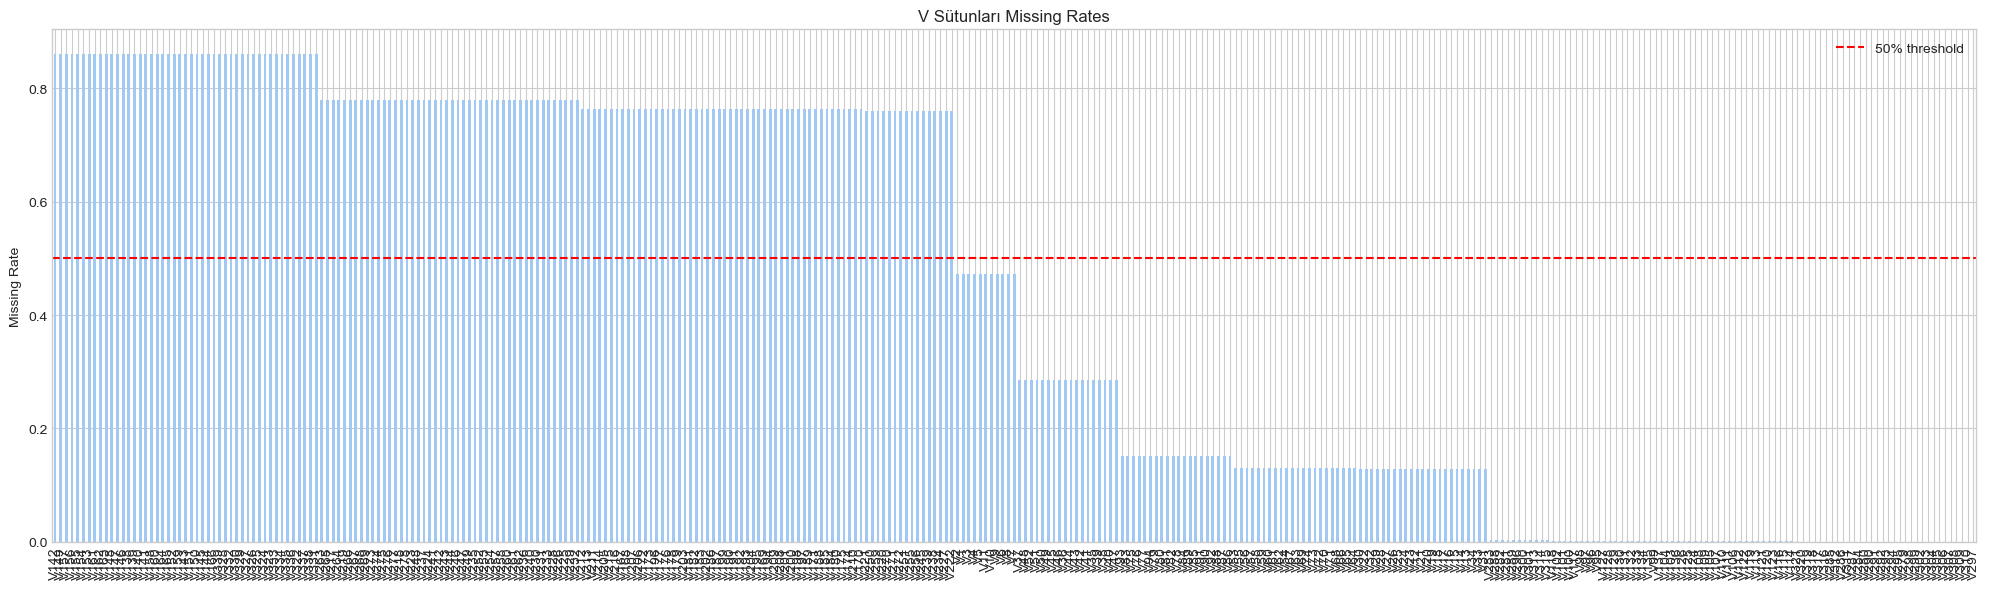

High missing V columns (>90%): 0


In [ ]:
v_missing = train_df[v_cols].isnull()

missing_rates = v_missing.mean().sort_values(ascending=False)

plt.figure(figsize=(20, 6))
missing_rates.plot(kind='bar')
plt.title('V Sütunları Missing Rates')
plt.ylabel('Missing Rate')
plt.xlabel('V Columns')
plt.axhline(0.5, color='red', linestyle='--', label='50% threshold')
plt.legend()
plt.tight_layout()
plt.show()

Missing value bakımından bağımlı sütunları bulmaya çalışalım.

In [21]:
v_pattern_groups = group_by_missing_pattern(train_df, v_cols)

print("Exact Missing-Pattern Grouping Summary")
print("--------------------------------------")
print(f"Total V columns: {len(v_cols)}")
print(f"Unique missing patterns: {len(v_pattern_groups)}\n")

# Sort groups by size
sorted_groups = sorted(
    v_pattern_groups.items(),
    key=lambda x: x[1]['size'],
    reverse=True
)

print("Top Missing-Pattern Groups")
print("--------------------------")

for pattern_id, info in sorted_groups[:15]:
    cols = info['columns']
    print(f"Group {pattern_id}")
    print(f"  Columns: {len(cols)}")
    print(f"  Missing rate: {info['missing_rate']:.2%}")
    print(f"  Example: {cols[:5]}")

    # Check if columns are consecutive.
    col_numbers = []
    for col in cols:
        try:
            col_numbers.append(int(col[1:]))
        except:
            pass

    if len(col_numbers) > 1:
        col_numbers.sort()
        is_consecutive = all(
            col_numbers[i+1] - col_numbers[i] == 1
            for i in range(len(col_numbers)-1)
        )
        if is_consecutive:
            print(f"  Consecutive columns: V{col_numbers[0]}–V{col_numbers[-1]}")

Exact Missing-Pattern Grouping Summary
--------------------------------------
Total V columns: 339
Unique missing patterns: 15

Top Missing-Pattern Groups
--------------------------
Group 11
  Columns: 46
  Missing rate: 77.91%
  Example: ['V217', 'V218', 'V219', 'V223', 'V224']
Group 6
  Columns: 43
  Missing rate: 0.05%
  Example: ['V95', 'V96', 'V97', 'V98', 'V99']
  Consecutive columns: V95–V137
Group 13
  Columns: 32
  Missing rate: 0.00%
  Example: ['V279', 'V280', 'V284', 'V285', 'V286']
Group 9
  Columns: 31
  Missing rate: 76.36%
  Example: ['V167', 'V168', 'V172', 'V173', 'V176']
Group 2
  Columns: 23
  Missing rate: 12.88%
  Example: ['V12', 'V13', 'V14', 'V15', 'V16']
  Consecutive columns: V12–V34
Group 4
  Columns: 22
  Missing rate: 13.06%
  Example: ['V53', 'V54', 'V55', 'V56', 'V57']
  Consecutive columns: V53–V74
Group 5
  Columns: 20
  Missing rate: 15.10%
  Example: ['V75', 'V76', 'V77', 'V78', 'V79']
  Consecutive columns: V75–V94
Group 10
  Columns: 19
  Missing r

In [22]:
representative_v = []

for pattern_id, info in v_pattern_groups.items():
    group_cols = info['columns']

    if len(group_cols) == 1:
        representative_v.extend(group_cols)
        continue

    # Use KS test for selecting most discriminative feature
    ks_res = test_feature_discrimination(train_df, group_cols, test='ks')

    if not ks_res.empty:
        best = ks_res.iloc[0]['Feature']
        representative_v.append(best)

print("Selected Representatives Summary")
print("--------------------------------")
print(f"Original V columns: {len(v_cols)}")
print(f"Selected representatives: {len(representative_v)}")
print(f"Reduction: {(1 - len(representative_v)/len(v_cols)) * 100:.1f}%")

Selected Representatives Summary
--------------------------------
Original V columns: 339
Selected representatives: 15
Reduction: 95.6%


In [24]:
train_df = train_df[train_df.columns.difference(v_cols).union(pd.Index(representative_v))]
v_cols = v_cols = [col for col in train_df.columns if col.startswith('V')]
# Böylece elimizdeki veriyi büyük ölçüde indirgemiş olduk ve v_col listesini güncelledik. 
# Artık aralarından en anlamlı olanlarla devam ediyoruz.


   Feature  Test_Stat  P_Value
0     V258     0.4621      0.0
1      V52     0.3901      0.0
2     V201     0.3863      0.0
3     V199     0.3748      0.0
4      V94     0.3644      0.0
5     V140     0.3540      0.0
6      V34     0.3523      0.0
7      V74     0.3357      0.0
8     V303     0.3156      0.0
9     V259     0.2994      0.0
10     V10     0.2806      0.0
11    V150     0.2499      0.0
12    V282     0.1955      0.0
13    V133     0.1792      0.0
14    V324     0.1475      0.0


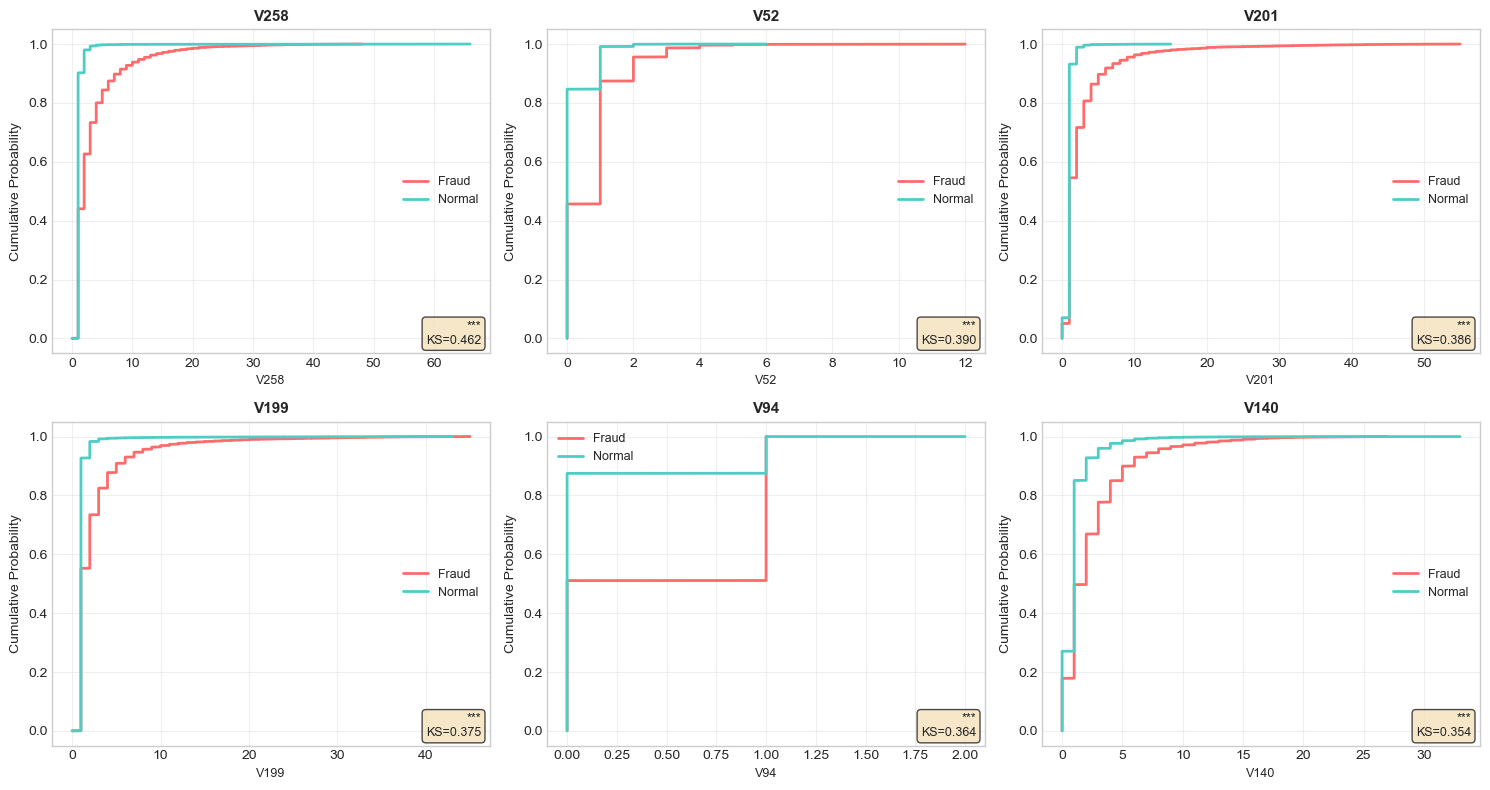

In [32]:
results = test_feature_discrimination(
    train_df, 
    columns=v_cols,
    test='ks'
)

print(results[['Feature', 'Test_Stat', 'P_Value']])

# En anlamlı 6 tansini görselleştiriyoruz sayı arttırılabilir.
top_6 = results.head(6)['Feature'].tolist()
plot_distribution_comparison(train_df, top_6, plot_type='cdf')

In [25]:
train_df.shape

(590540, 59)

Korelasyona bakarak veri analizi ve indirgeme.

id sütunları arasındaki korelasyo normal gibi gözüküyor. c_cols için ise bazı sütunlar birbirinin aynısı , v_cols lardan kalanlar içnde de yine yüksek korelasyonlu olanlar var..

In [37]:
# correlation_heatmap(train_df , columns = v_cols)
# buradan yine elenmesi gereken v_col çıkıyor...

In [28]:
c_groups = get_correlation_groups(train_df, c_cols, threshold=0.95)
c_repr, c_details = select_representatives_by_ks(train_df, c_groups)

v_groups = get_correlation_groups(train_df, v_cols, threshold=0.95)
v_repr_final, v_details = select_representatives_by_ks(train_df, v_groups)


final_features = c_repr + v_repr_final + d_cols + id_cols + indep_cols
train_df_final = train_df[final_features]


Correlation Groups (threshold=0.95):
   1. Group: 4 features -> ['C1', 'C2', 'C4', 'C11']
      Avg correlation: 0.987
   2. Group: 4 features -> ['C7', 'C8', 'C10', 'C12']
      Avg correlation: 0.991
   3. Group: 2 features -> ['C6', 'C14']
      Avg correlation: 0.992

Selected Representatives from 3 groups:
   Group 1 (4 features): C4 (KS=0.331)
   Group 4 (2 features): C14 (KS=0.198)
   Group 5 (4 features): C8 (KS=0.316)

Correlation Groups (threshold=0.95):
   1. Group: 2 features -> ['V133', 'V324']
      Avg correlation: 0.993

Selected Representatives from 1 groups:
   Group 2 (2 features): V133 (KS=0.179)


In [29]:
print(f"TRAIN SET - Feature Reduction Summary")
print(f"{'='*60}")
print(f"  Original: {train_df.shape[1]} features")
print(f"  Selected: {len(final_features)} features")
print(f"  Reduction: {(1 - len(final_features)/train_df.shape[1])*100:.1f}%")

TRAIN SET - Feature Reduction Summary
  Original: 59 features
  Selected: 51 features
  Reduction: 13.6%


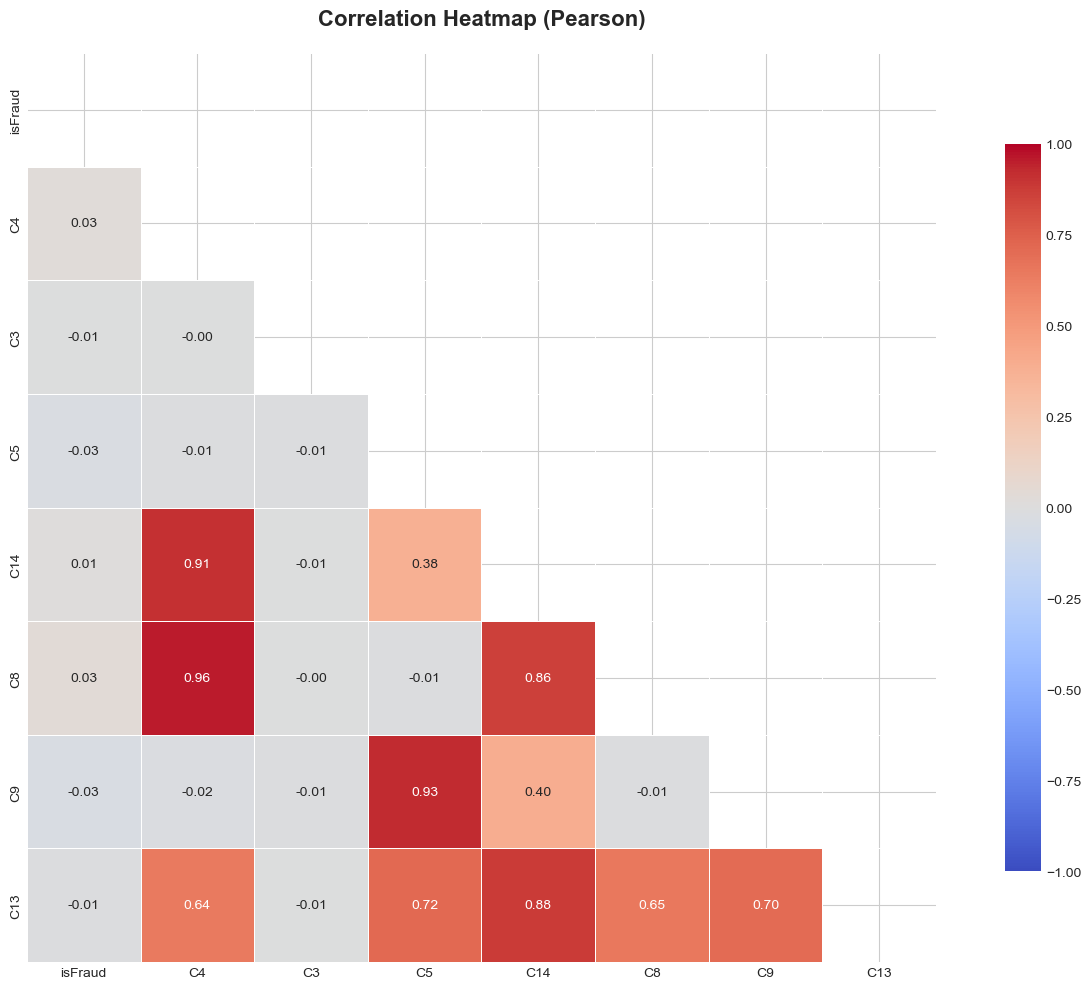

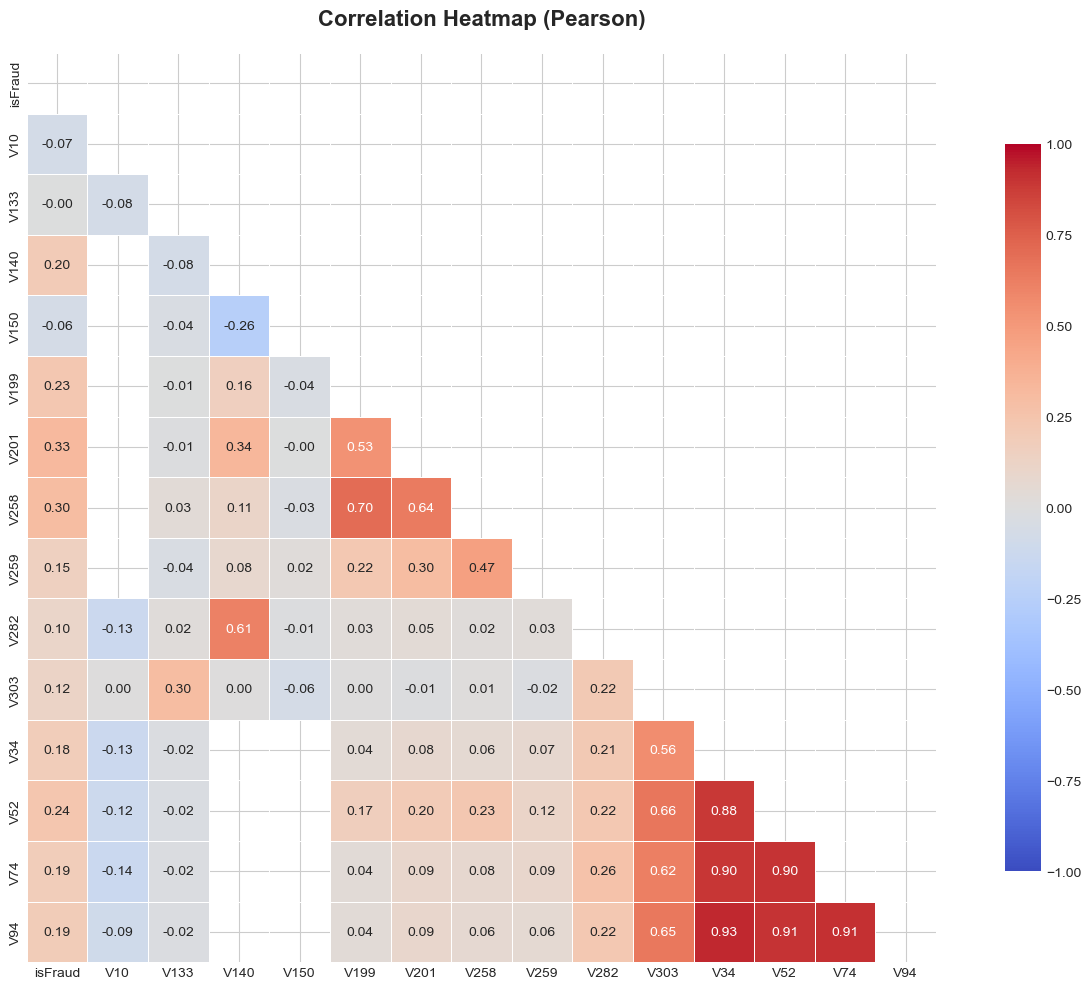

In [31]:
corr_c = correlation_heatmap(train_df , columns = c_repr)
corr_v = correlation_heatmap(train_df , columns = v_repr_final)